# LBO graph
This code plots time-series variation in buyout activity. 

Variables: 
1. The volume measure is the aggregrate quarterly deal volume. It includes complete M&A deals that both target and acquirer firms are in the U.S. and the transacation value is greater than 1 million.

2. LBO buyout: follows HLP 2016's selecting criteria, it contains two parts: part 1 includes the deals for public targets that are described as a "leverage buyout" or "management buyout"; part 2 screens for additional transations by including public firms purchased by private financial acquirers.

3. Expected returns: computed by using HLP 2016's code

4. Interest rate: 
    10-Year Treasury Constant Maturity Rate (GS10)
    1-Year Treasury Constant Maturity Rate (GS1)
    
5. Scaled_Volume: scaled by total market cap 
    
Input: 
1. "MA_1977_1980.xls",etc: M&A deals that downloaded from Thomson One database
2. "predict.csv": includes excess expected return 
3. "GS10.csv" and "GS1.csv": monthly interest rate
4. "compustat.csv": financial data downloaded from WRDS to compute market cap

Output:
1. "LBO.png": LBO - risk premium - interest rates
2. "Non_LBO.png": Non LBO deals - risk premium - interest rates
3. "ALL_MA.png": All M&A deals - risk premium - interest rates

## 1. Clean Dataset

In [1]:
## import packages
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
## read dataset
file_names =  glob.glob("../input/MA*.xls")
dfs = [pd.read_excel(file_name, sheet_name = 0, skiprows = 2 ) for file_name in file_names]
result = pd.concat(dfs)
result = result.reset_index(drop = True)

In [3]:
## clean column names
raw_column_name = result.columns
temp_column_name = [name.replace('\n', ' ').replace("/", "").replace(".1"," Real") for name in raw_column_name]
temp_column_name = [name.replace('%', 'Percent').replace("  "," ").replace("Trans- action", "Transaction")  for name in temp_column_name]
temp_column_name = [name.replace('.', "").lstrip() for name in temp_column_name]
result.columns = temp_column_name

## 2. LBO Volume

In [4]:
## part 1: leverage buyout/ management buyout
part1 = result
part1 = part1[part1["Target Public Status"] == "Public"]
LBO_data1 =  part1[["Leveraged Buyout" in technique for technique in part1["Acquisition Technique"]]]
MBO_data =  part1[["Management Buyout" in technique for technique in part1["Acquisition Technique"]]]

In [5]:
## part 2: private financial acquirer
part2 = result
part2 = part2[part2["Target Public Status"] == "Public"]
part2 = part2[part2["Acq Public Status"] == "Priv."]
part2 = part2[["Financial Acquiror" in technique for technique in part2["Acquisition Technique"]]]

In [6]:
## combine two parts together 
LBO_data = pd.concat([LBO_data1, MBO_data, part2])
LBO_data = LBO_data.drop_duplicates()
others = result.drop(LBO_data.index)

In [7]:
## count quarterly volume
def get_resample(curr_data):
    case_count = curr_data.groupby("Date Announced").count()["Date Effective"]
    case_count.index = pd.to_datetime(case_count.index)
    resample = case_count.resample("Q").sum()
    return resample

In [8]:
## get resample data
LBO_resample = get_resample(LBO_data)
Non_LBO_resample = get_resample(others)
all_resample = get_resample(result)

## 3. Interest Rate

In [9]:
## read interest rate data
gs1 = pd.read_csv("../input/GS1.csv")
gs10 = pd.read_csv("../input/GS10.csv")

In [10]:
## define function to clean interest rate data
def clean_ir(curr_interest):
    curr_interest["date"]  = pd.to_datetime(curr_interest["dateym"].astype(str), format = "%Y%m")
    curr_interest.index = curr_interest["date"]
    ir = curr_interest["rf"]
    ir = ir.resample("Q").mean()
    ir_aligned = ir[LBO_resample.index]
    return ir_aligned

In [11]:
## clean interest rate
rf1 = clean_ir(gs1)
rf10 = clean_ir(gs10)

## 4. Risk Premium

In [12]:
## read risk premium dataset
HLB_table = pd.read_csv("../input/predict.csv", header = 0)
HLB_table["date"]  = pd.to_datetime(HLB_table["dateym"].astype(str), format = "%Y%m")

In [13]:
## clean risk premium dataset
HLB_table.index = HLB_table["date"]
risk_premium = HLB_table["exp_rmrf"]
risk_premium  = risk_premium.resample("Q").sum()
risk_premium_aligned = risk_premium[LBO_resample.index]

## 5. Market Cap

In [15]:
import zipfile

In [19]:
## read compustat dataset
zf = zipfile.ZipFile("../input/compustat.zip")
compustat = pd.read_csv(zf.open("compustat.csv"), header = 0)

In [20]:
## compute market cap
df = compustat
df["mkt_cap"] = df["prccq"] * df["cshoq"]
df2 = df.groupby("datafqtr").sum()["mkt_cap"]
df2.index = pd.to_datetime(df2.index)
resample = df2.resample("Q").sum()
mkt_cap = resample

## 6. Plot

In [16]:
## choose date range
dates = LBO_resample.index
start_date = '1982-12-31'
end_dates = '2019-12-31'
dates = dates[(dates >= start_date) &  (dates <= end_dates)]

In [22]:
## define function to plot graphs
def get_plot(resample, dates, title = "LBO"):
    plt.rcParams["figure.figsize"] = (30,10)
    fig, ax = plt.subplots(figsize=(30,10))


    ax.bar(dates, 
             resample[dates].values,  
             width=80,  
             align='center') 
    ax.set_xlabel(xlabel = "year", fontsize = 20)
    ax.set_ylabel(ylabel = "M&A volume", fontsize = 20)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)

    ax2 = ax.twinx()
    ax2.plot(risk_premium_aligned[dates] * 100, color = "black", label = "Expected Risk Premium")
    ax2.plot(rf1[dates] * 100, color = "red", label = "1Y Treasury CMR")
    ax2.plot(rf10[dates] * 100, color = "green", label = "10Y  Treasury CMR")
    ax2.set_ylabel(ylabel = "Risk Premium/ Risk Free Rate", fontsize = 20)
    leg = ax2.legend(prop={'size': 20})
    ## plot of risk premium

    plt.title("{} Volume V.S. Risk Preimum and Interest Rate".format(title), fontsize = 20)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.savefig("../output/" + title )
    plt.show()

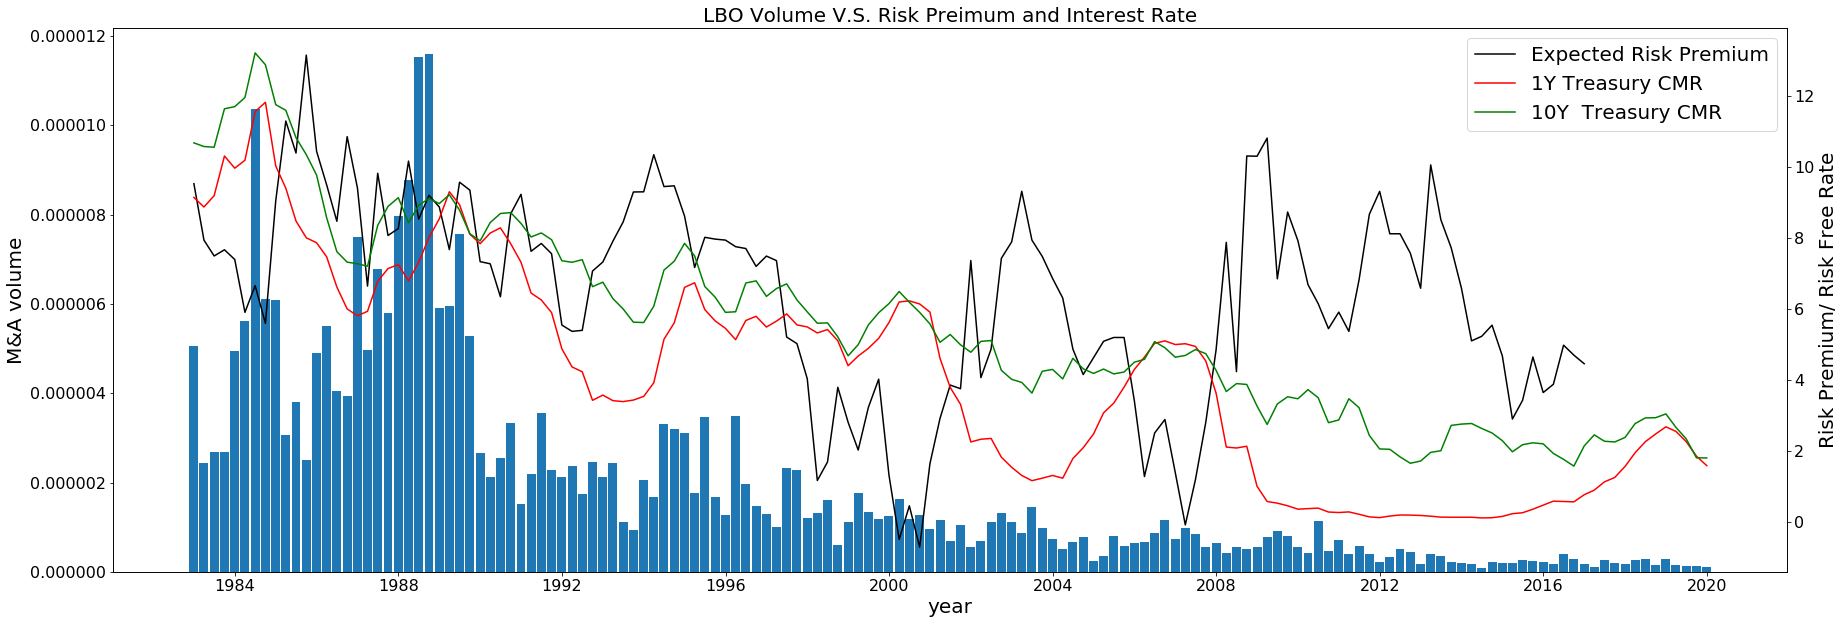

In [23]:
get_plot(LBO_resample/mkt_cap, dates)

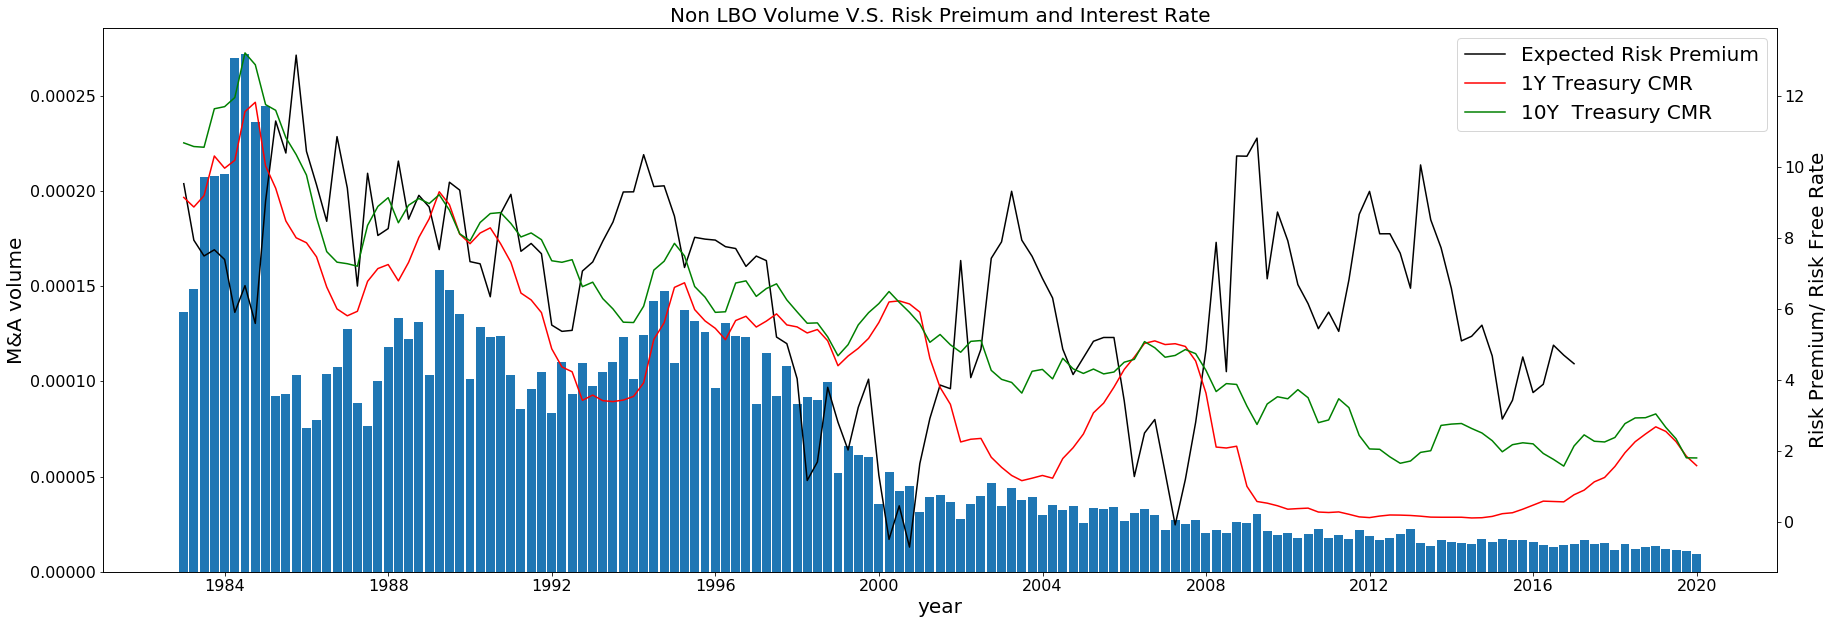

In [24]:
get_plot(Non_LBO_resample/mkt_cap, dates, "Non LBO")

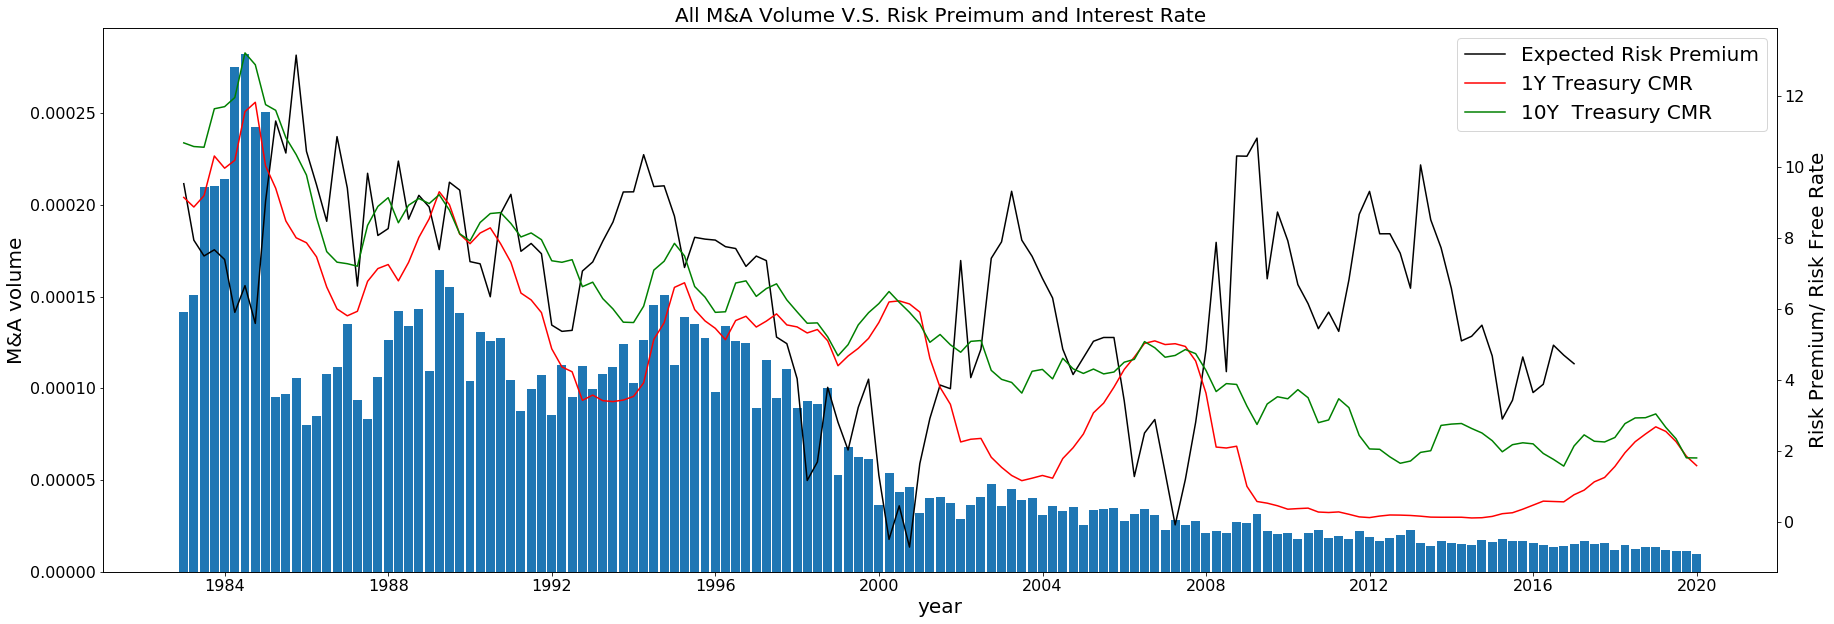

In [25]:
get_plot(all_resample/mkt_cap, dates, "All M&A")

In [26]:
np.corrcoef(Non_LBO_resample[dates], rf10[dates])[0, 1]

-0.24151399834335538